In [1]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle

import os, shutil
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('INFO')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy as cgi
from cgi_phasec_poppy import misc

from wfsc import iefc_2dm as iefc
from wfsc import utils


INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [2]:
# data_set_name = 'hlc_annular_iefc_sim_v1'
# data_set_name = 'hlc_annular_iefc_39_sim_v1'
data_set_name = 'hlc_annular_iefc_39_sim_v2'

iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')


In [3]:
response_cubes = misc.load_pickle(iefc_dir/data_set_name/'response_cubes')
images = misc.load_pickle(iefc_dir/data_set_name/'images')
dm1_acts = misc.load_pickle(iefc_dir/data_set_name/'dm1_acts')
dm2_acts = misc.load_pickle(iefc_dir/data_set_name/'dm2_acts')

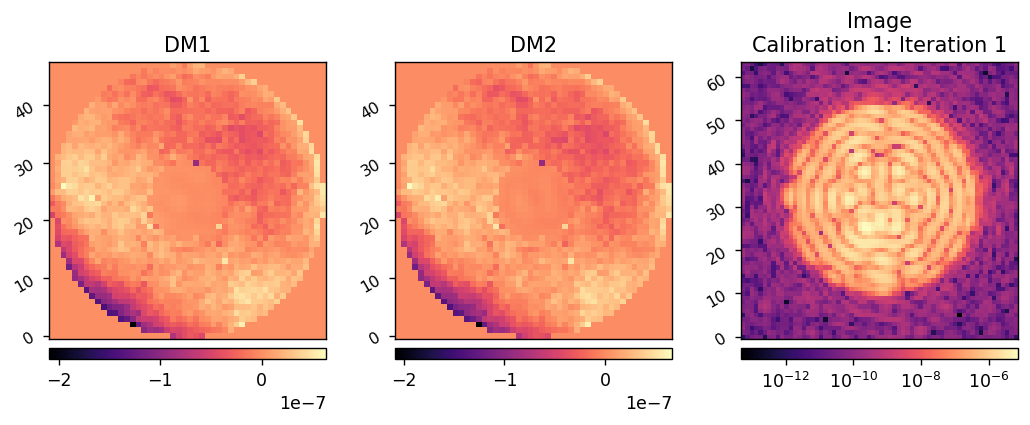

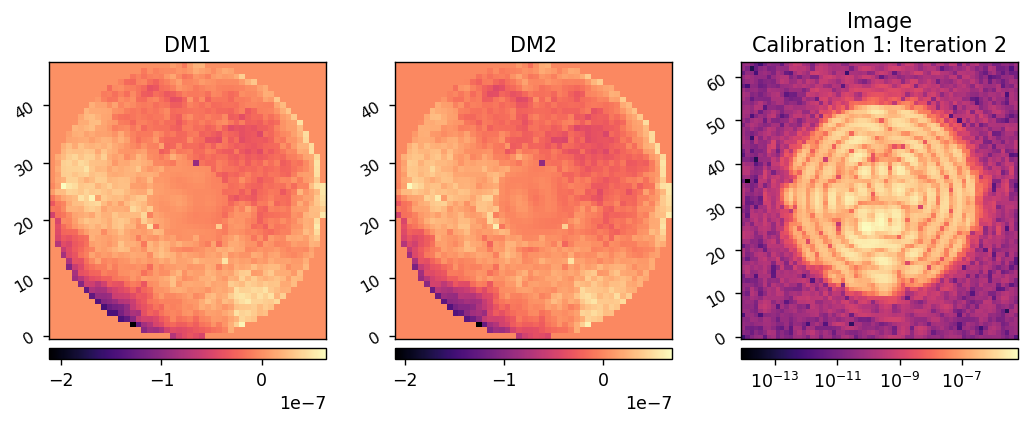

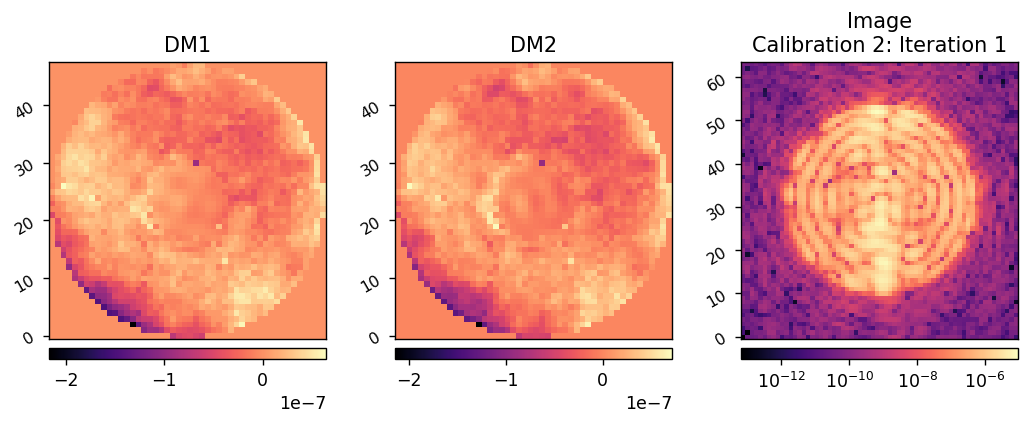

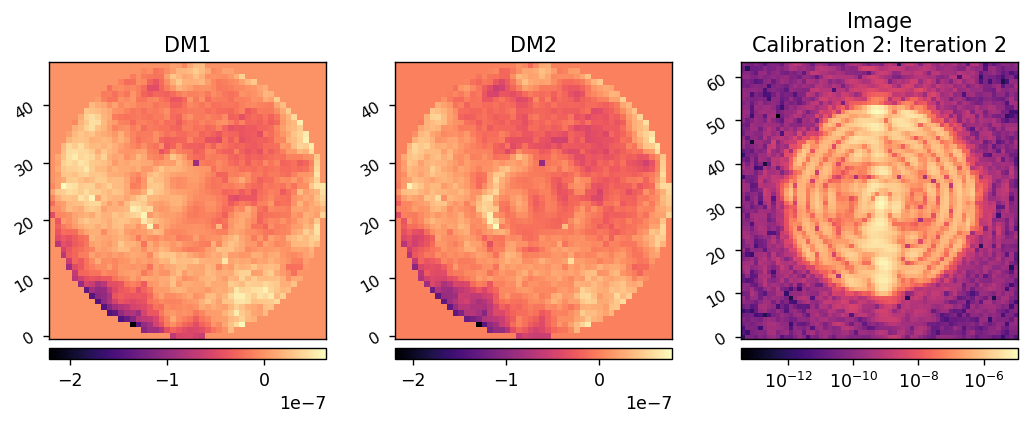

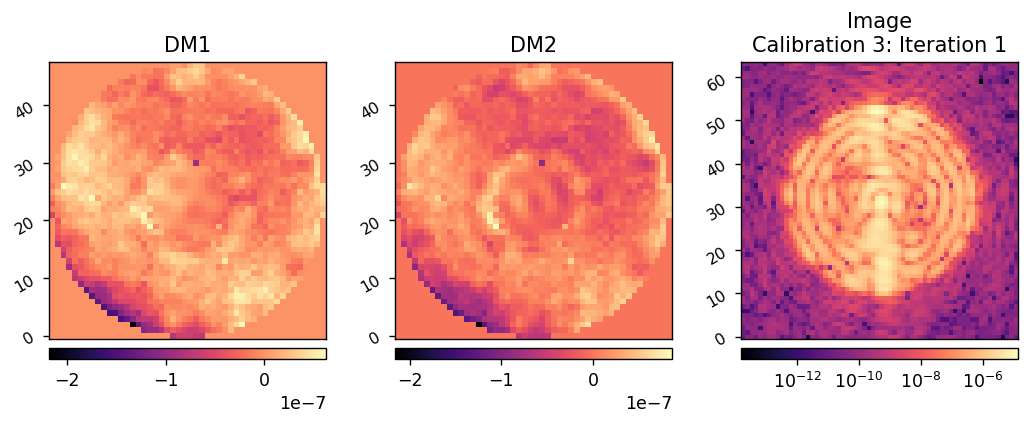

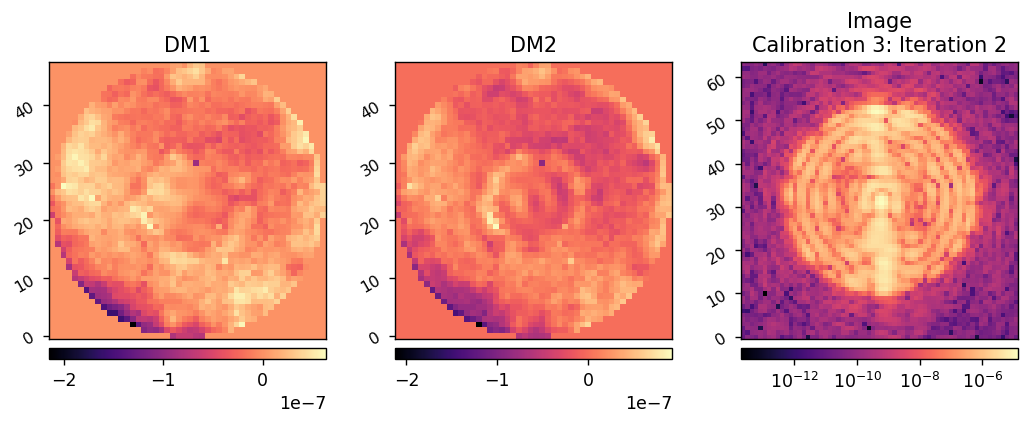

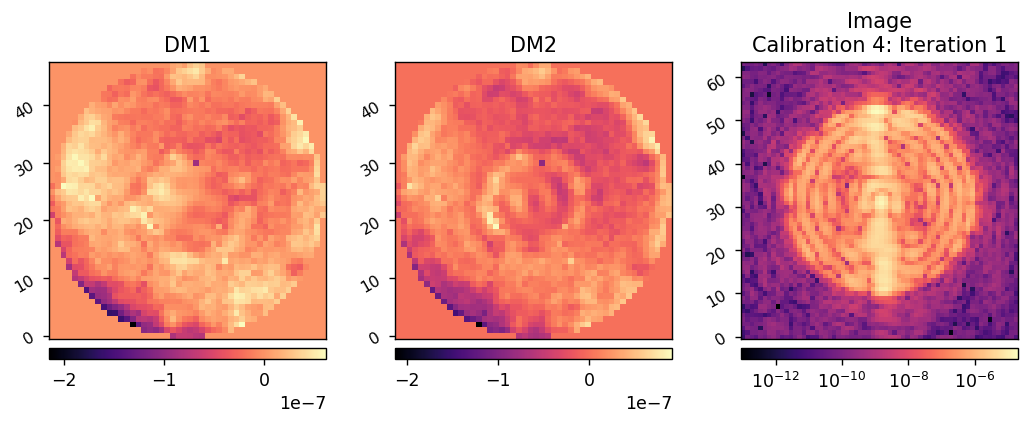

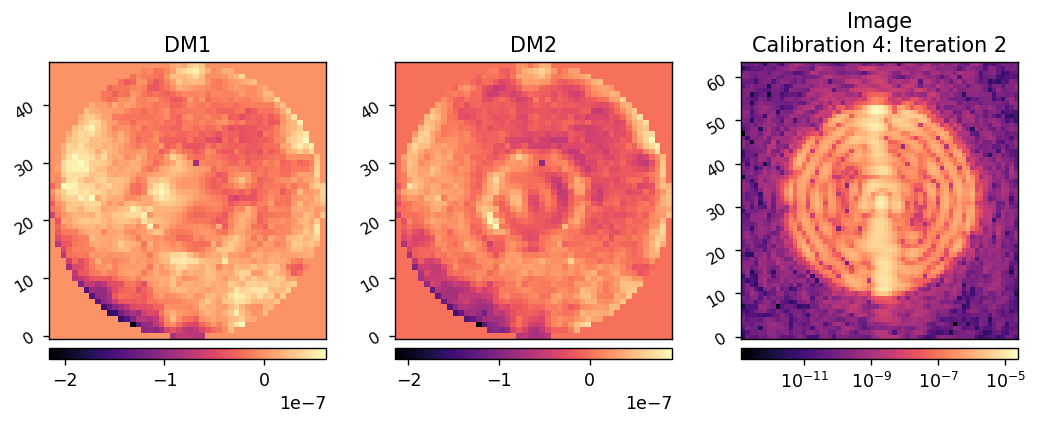

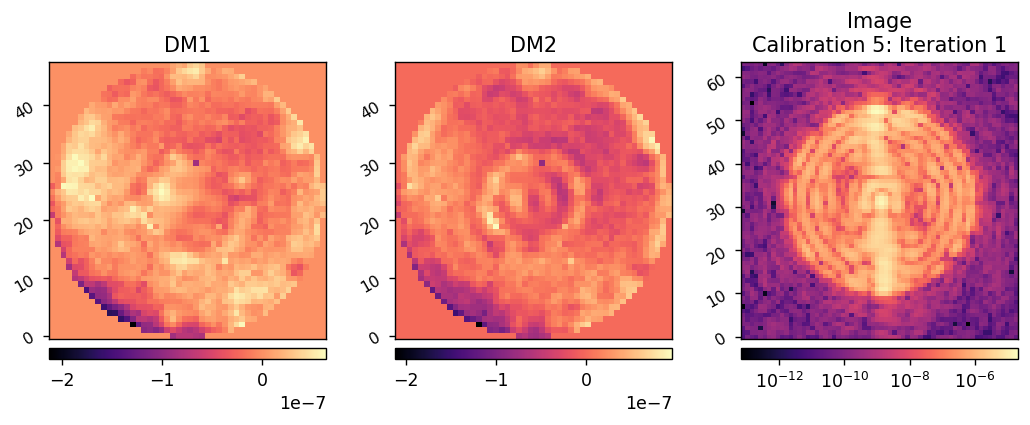

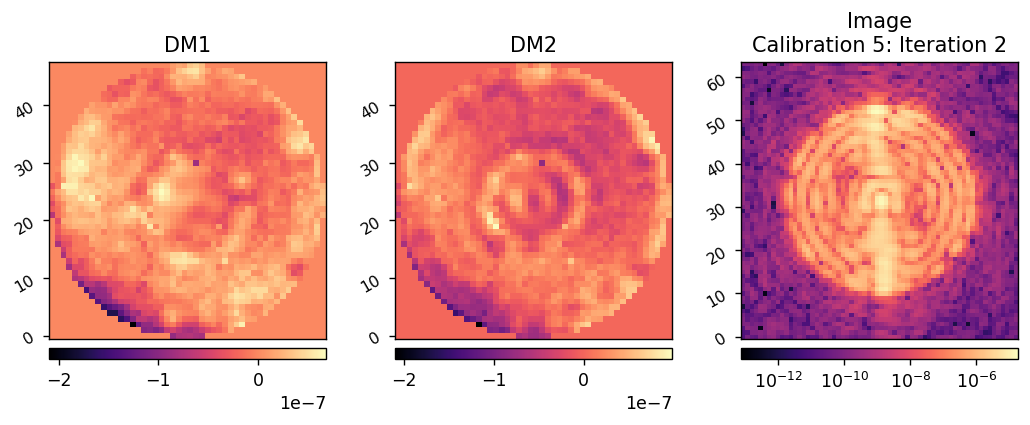

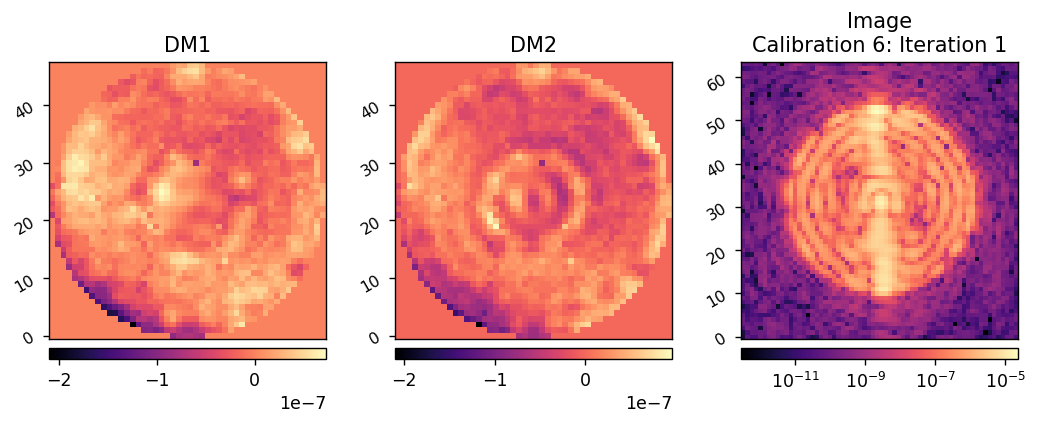

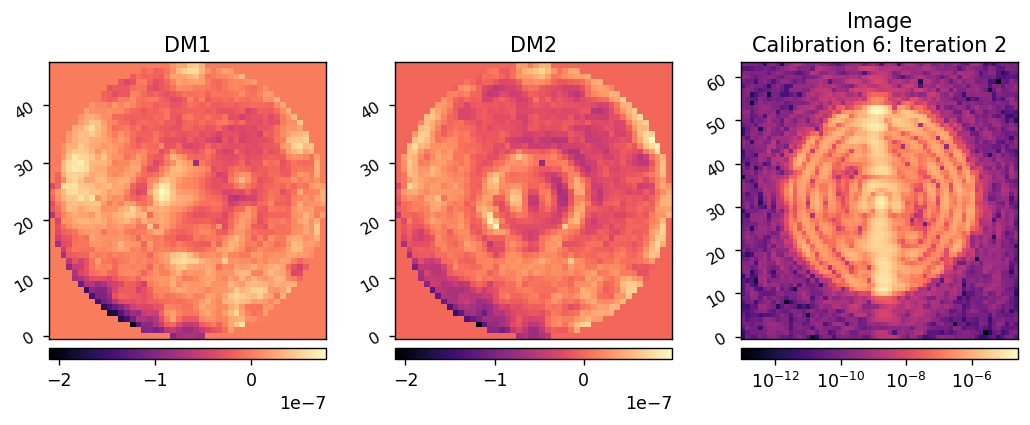

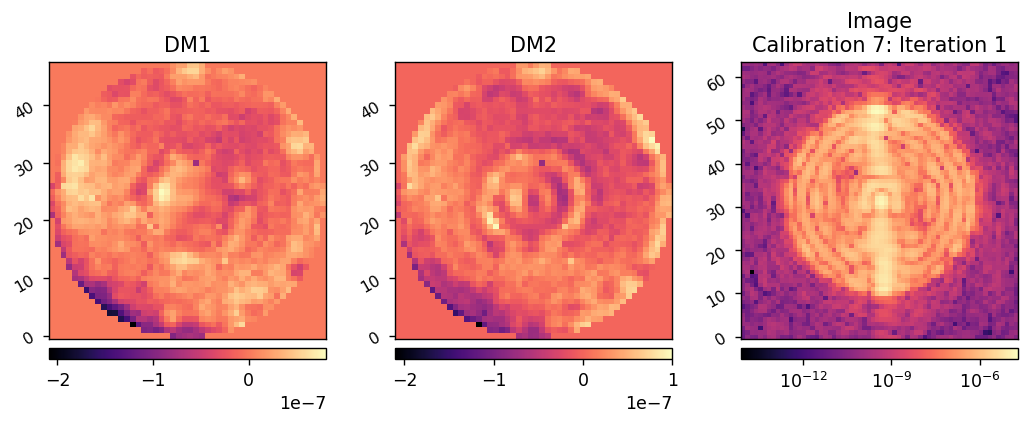

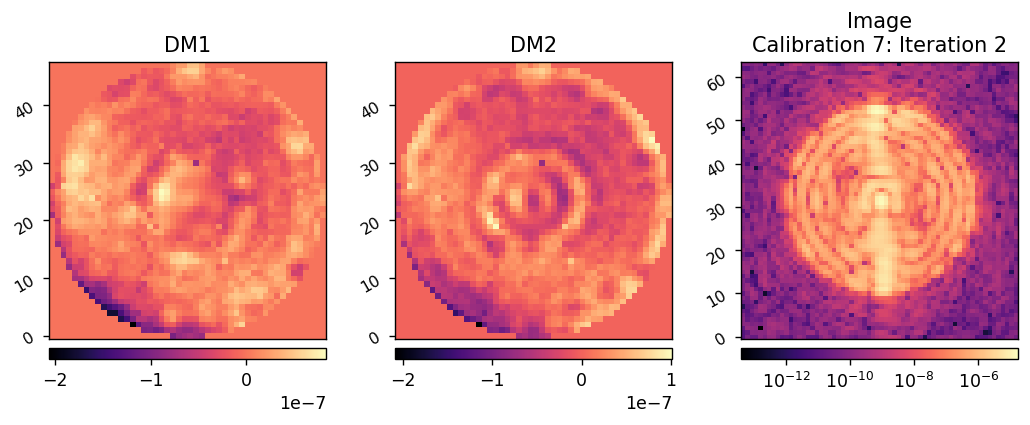

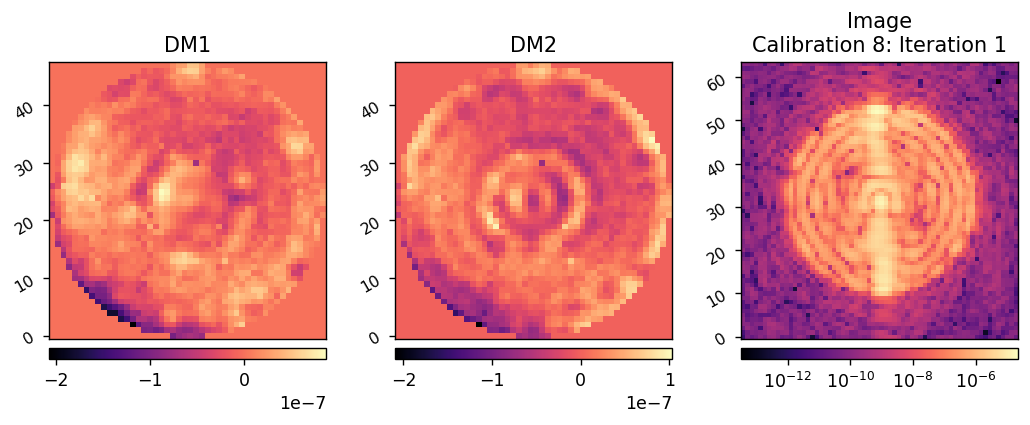

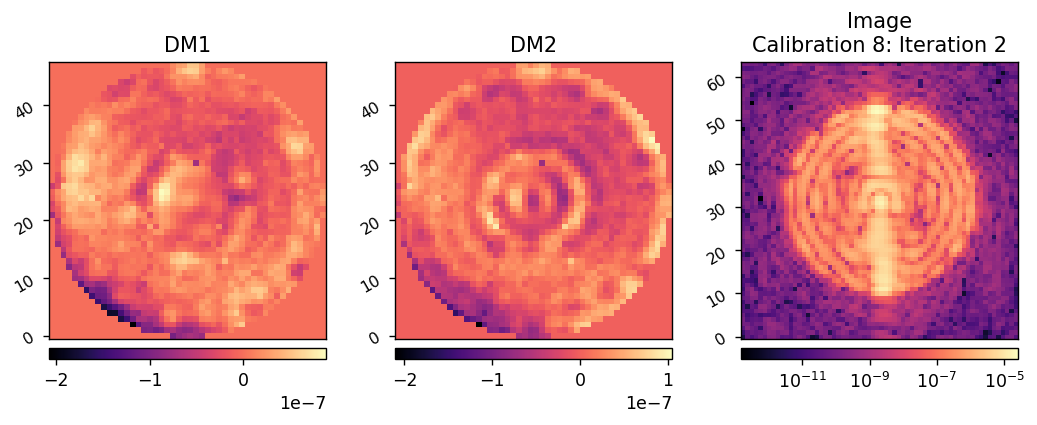

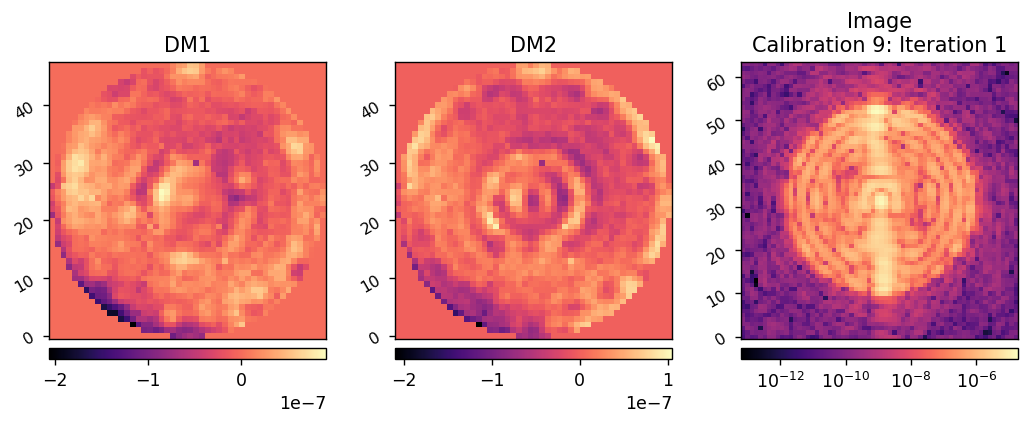

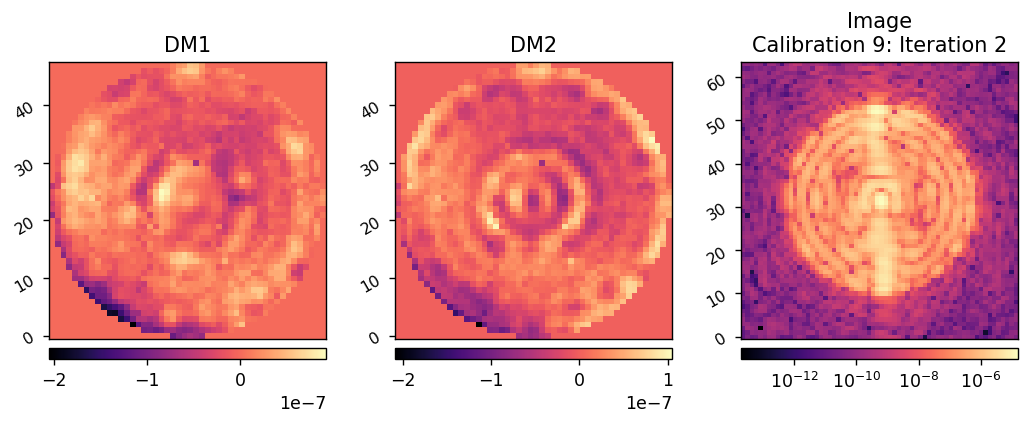

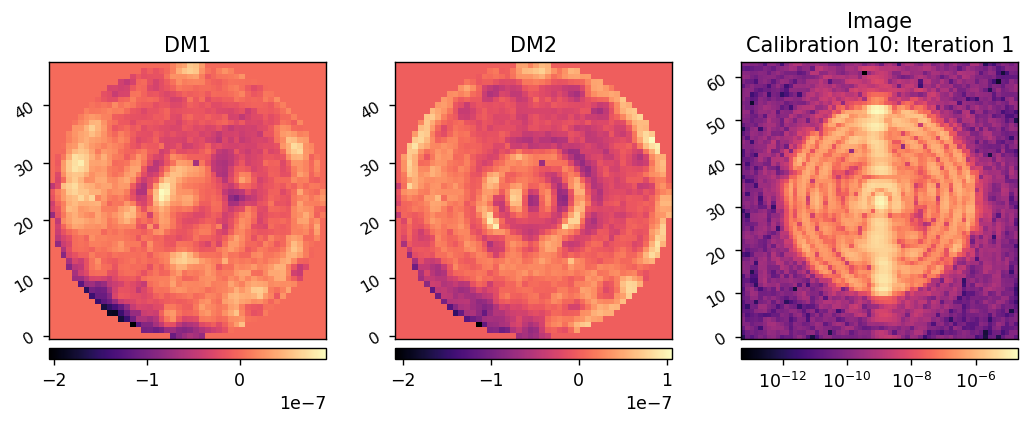

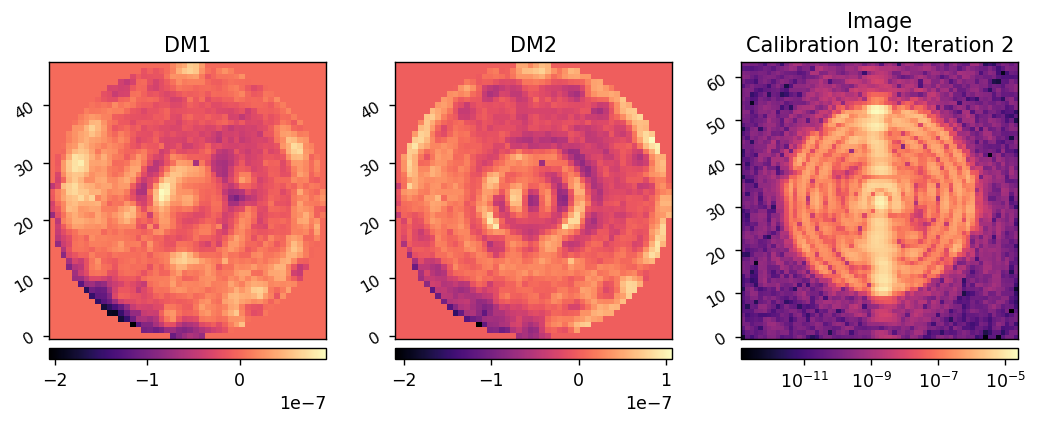

In [4]:
n_calibrations = 10
n_iefc_iterations_per_calib = 2

for i in range(n_calibrations):
    for j in range(n_iefc_iterations_per_calib):
        misc.myimshow3(dm1_acts[i,j], dm2_acts[i,j], images[i,j], 
                       'DM1', 'DM2', 'Image\nCalibration {:d}: Iteration {:d}'.format(i+1,j+1), 
                       lognorm3=True,)

In [6]:
0.006*575e-9, 0.05*575e-9

(3.45e-09, 2.8750000000000003e-08)

# Rerun with different regularizations

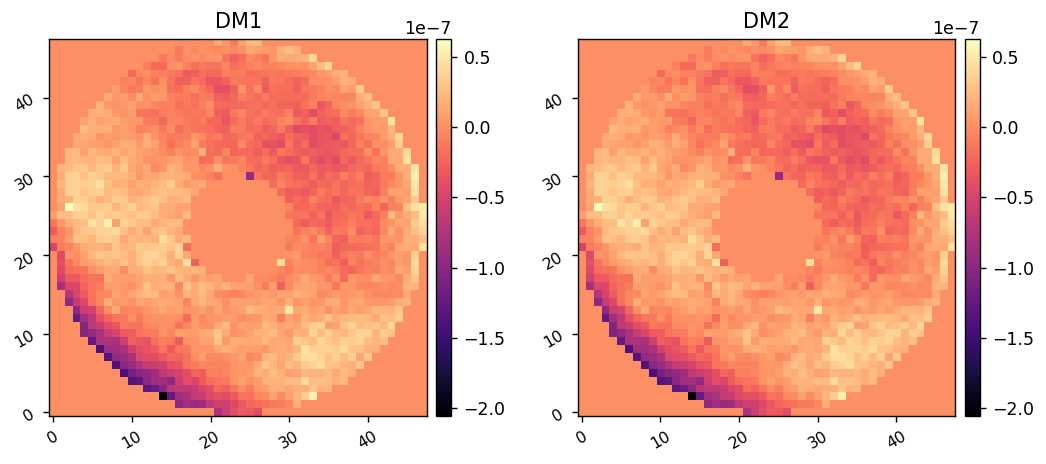

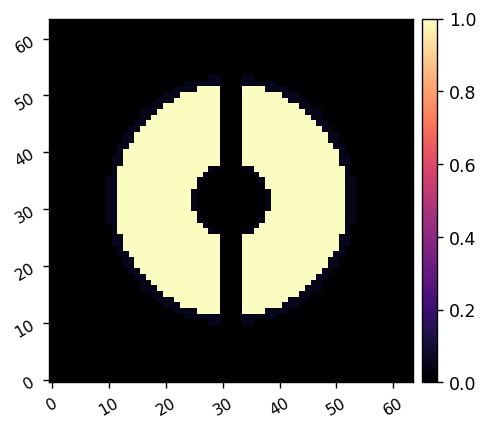

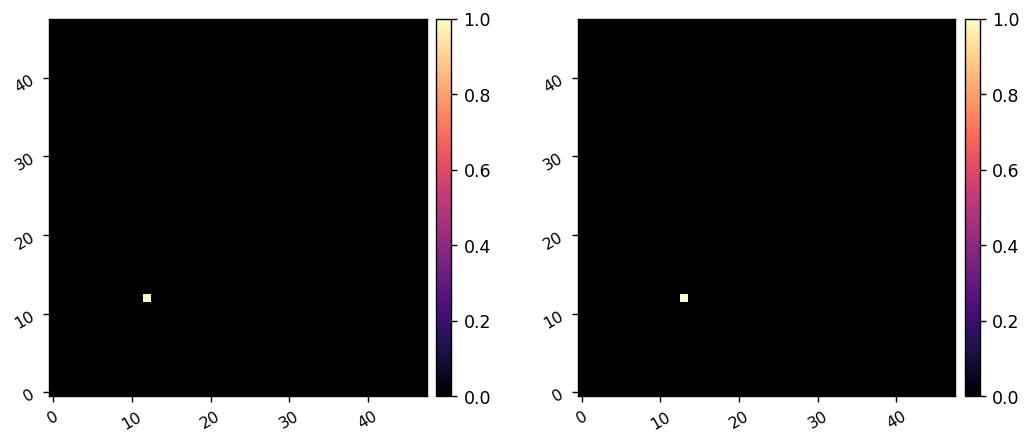

Creating Fourier modes:  (64, 64)
Calibration modes required: 592


In [6]:
dm_dir = cgi.data_dir/'dm-acts'

dm1_flat = 2*fits.getdata(dm_dir/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(dm_dir/'flatmaps'/'hlc_flattened_dm2.fits')

hlc = cgi.CGI(cgi_mode='hlc', 
              use_fpm=True,
              use_pupil_defocus=False, 
              polaxis=0,
              use_opds=True,
              dm1_ref=dm1_flat, dm2_ref=dm2_flat,
             )
hlc.show_dms()

npsf = hlc.npsf
Nact = hlc.Nact

reload(utils)
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * hlc.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 1
iwa = 3
owa = 9
rot = 0

# Create the dark-hole mask.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : '+x',
    'rotation':rot,
    'full':True,
}
dh_mask = utils.create_annular_focal_plane_mask(xf, yf, dh_params).ravel()

# Create the control region mask.
control_params = {
    'inner_radius' : iwa-0.2,
    'outer_radius' : owa+0.7,
    'edge_position' : edge,
    'rotation':rot,
    'full':True,
}
control_mask = utils.create_annular_focal_plane_mask(xf, yf, control_params).ravel()

relative_weight = 0.95
weights = dh_mask * relative_weight + (1 - relative_weight) * control_mask
misc.myimshow(weights.reshape(npsf,npsf))

# Create probe and calibration modes
probe_modes = iefc.create_probe_poke_modes(Nact, 
                                           xinds=[Nact//4, Nact//4+1],
                                           yinds=[Nact//4, Nact//4], 
                                           display=True)

calibration_modes, fx, fy = iefc.create_fourier_modes(xfp, 
                                                      control_mask.reshape((npsf,npsf)), 
                                                      Nact, 
                                                      circular_mask=False)
calibration_modes[:] *= hlc.dm_mask.flatten()

nmodes = calibration_modes.shape[0]
print('Calibration modes required: {:d}'.format(nmodes))

calibration_amplitude = 0.006 * hlc.wavelength_c.to(u.m).value
probe_amplitude = 0.05 * hlc.wavelength_c.to(u.m).value

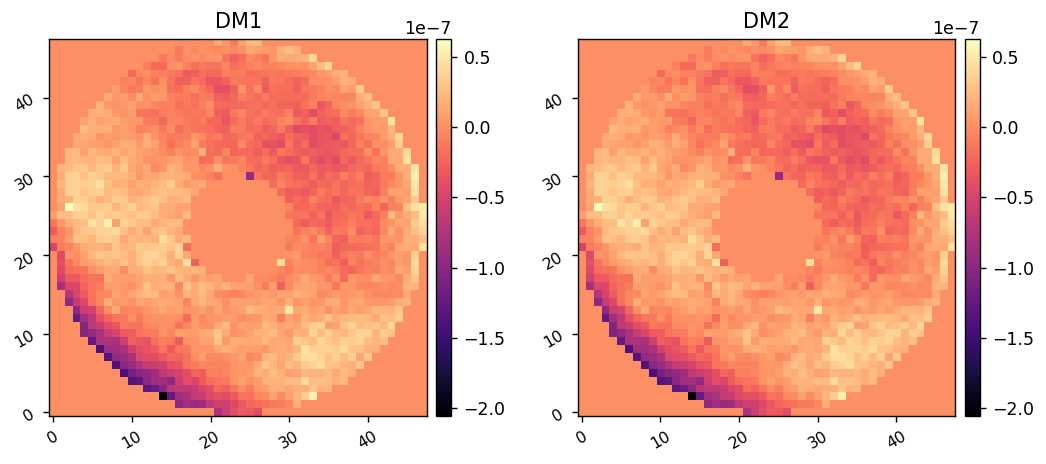

Calibration iteration 1


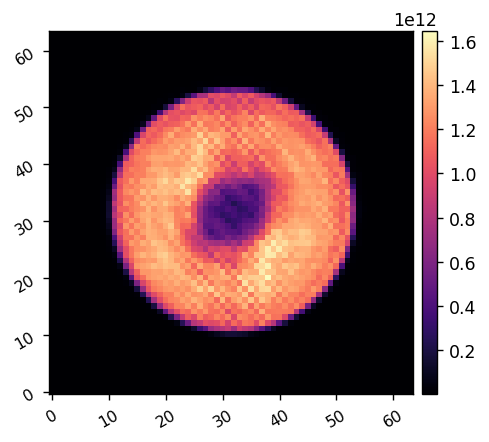

Using Weighted Least Squares 
Running I-EFC...
	Closed-loop iteration 1 / 5


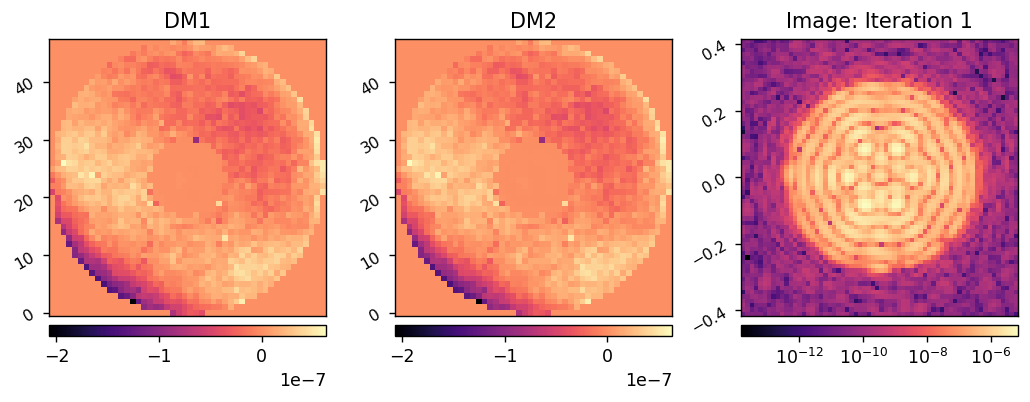

	Closed-loop iteration 2 / 5


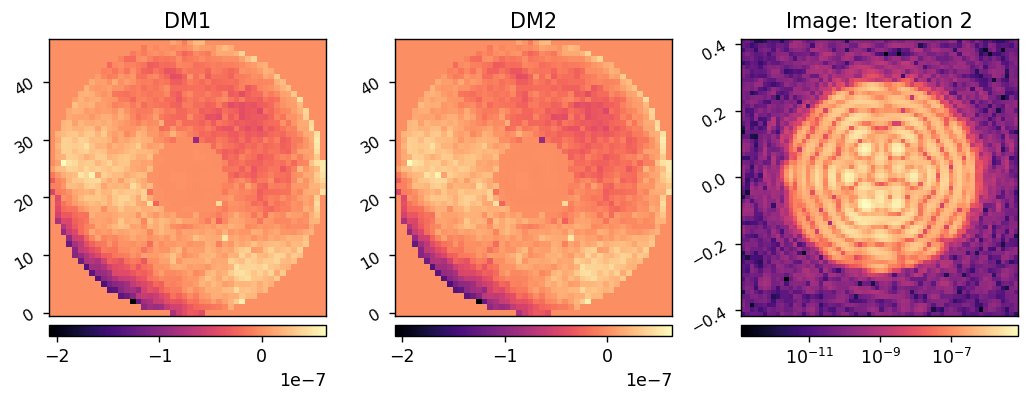

	Closed-loop iteration 3 / 5


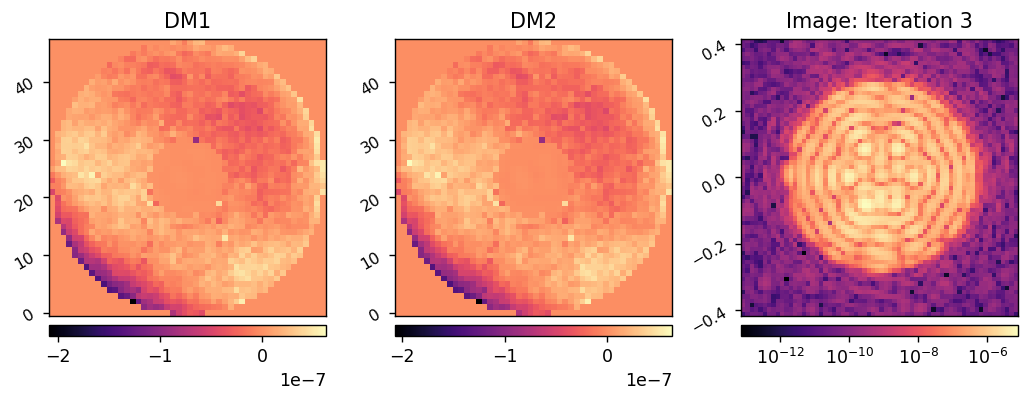

	Closed-loop iteration 4 / 5


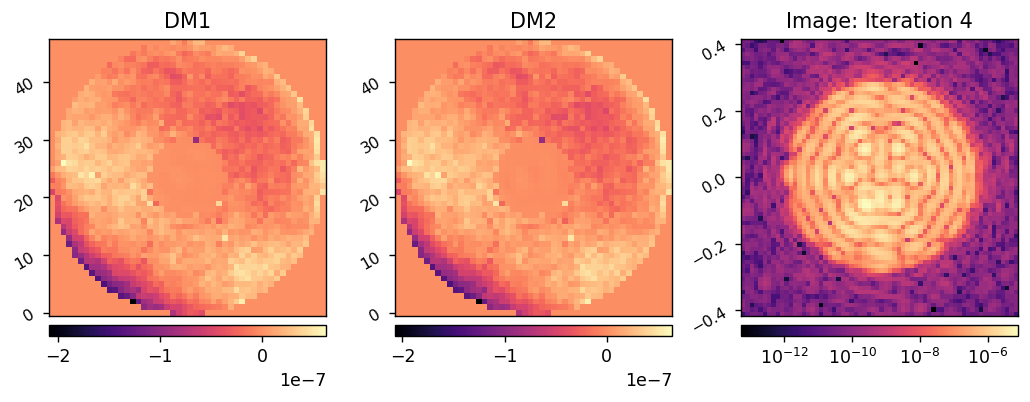

	Closed-loop iteration 5 / 5


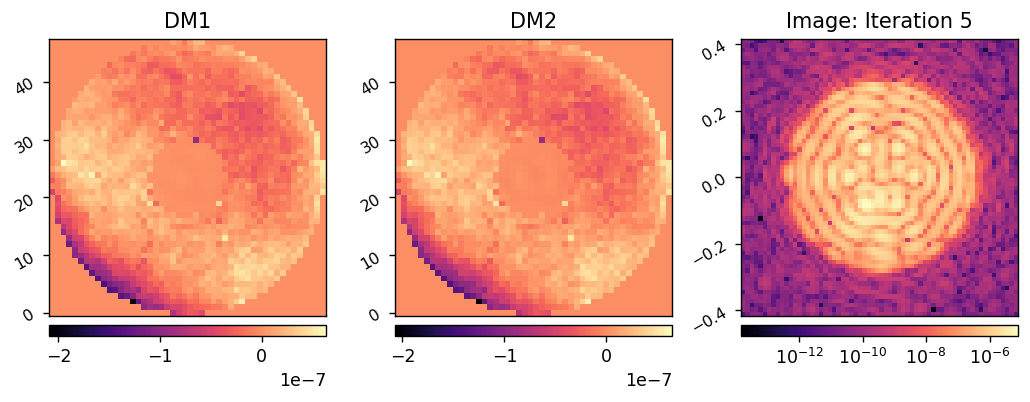

I-EFC loop completed in 10.126s.
Calibration iteration 2


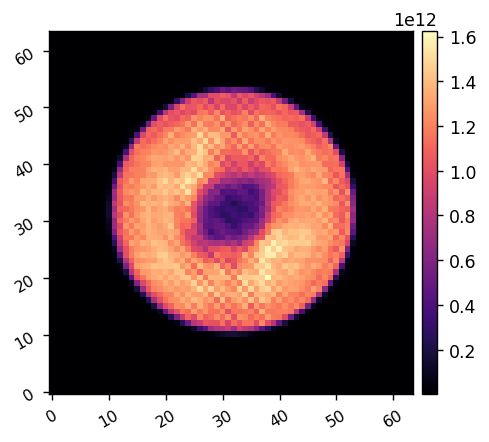

Using Weighted Least Squares 
Running I-EFC...
	Closed-loop iteration 1 / 5


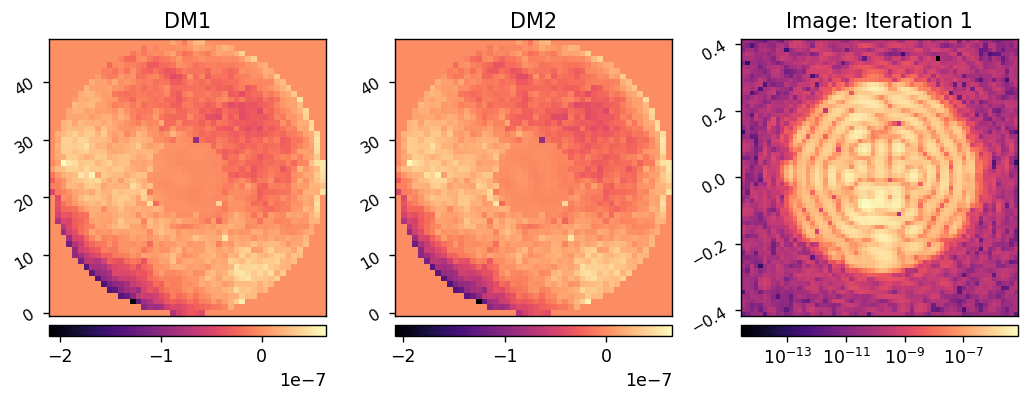

	Closed-loop iteration 2 / 5


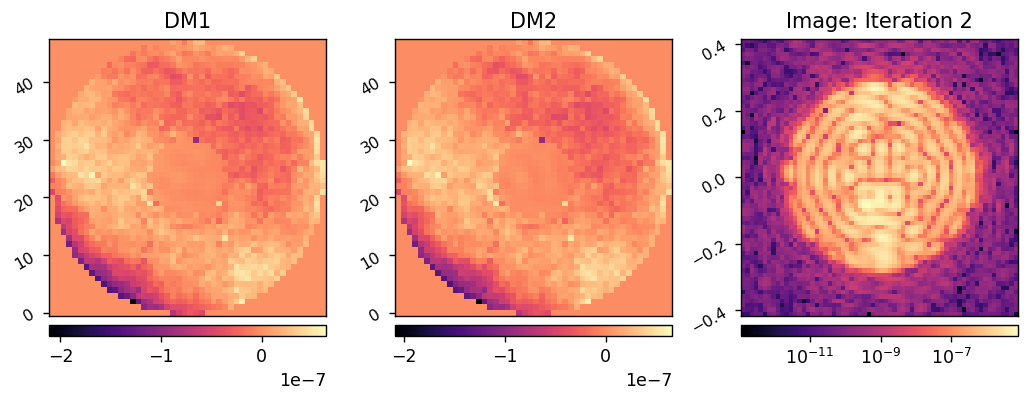

	Closed-loop iteration 3 / 5


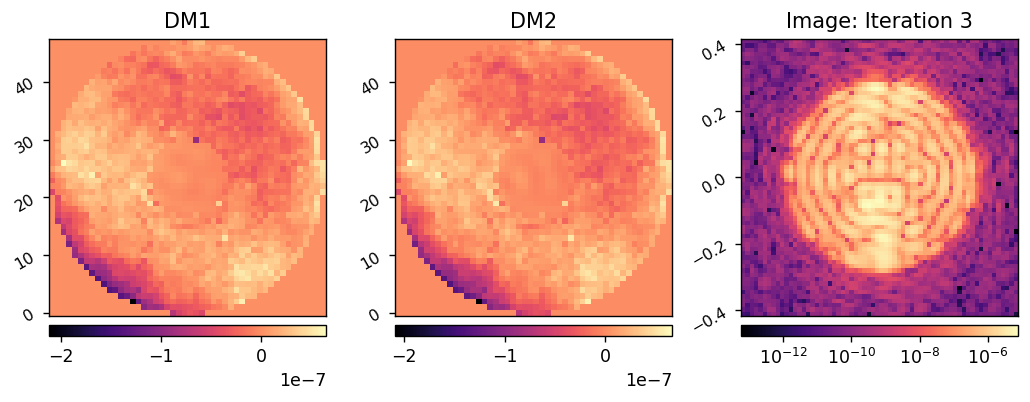

	Closed-loop iteration 4 / 5


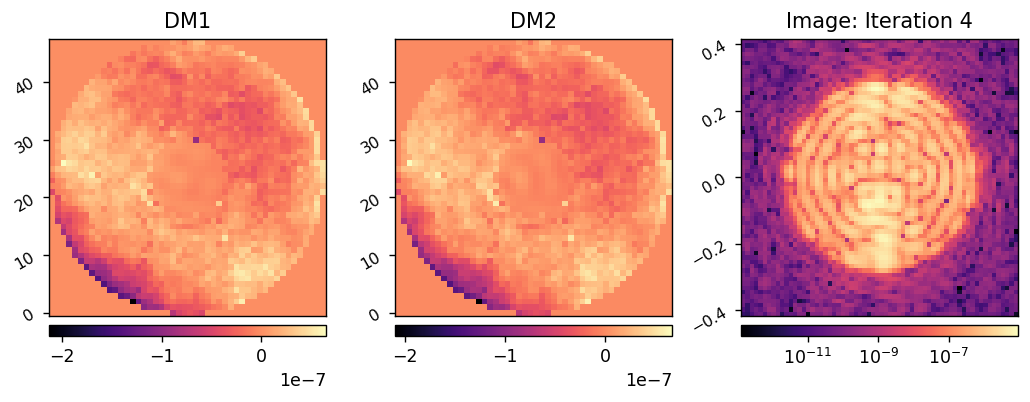

	Closed-loop iteration 5 / 5


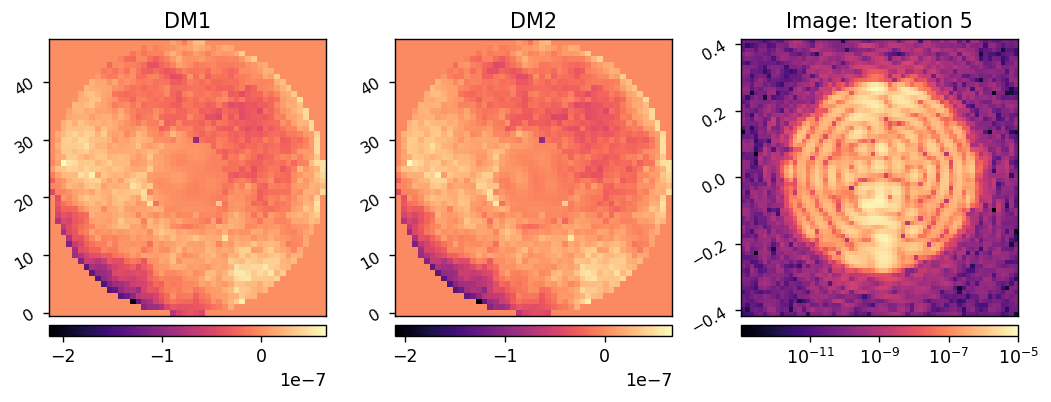

I-EFC loop completed in 9.838s.
Calibration iteration 3


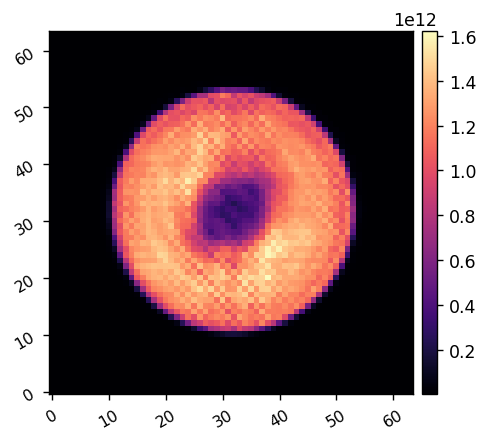

Using Weighted Least Squares 
Running I-EFC...
	Closed-loop iteration 1 / 5


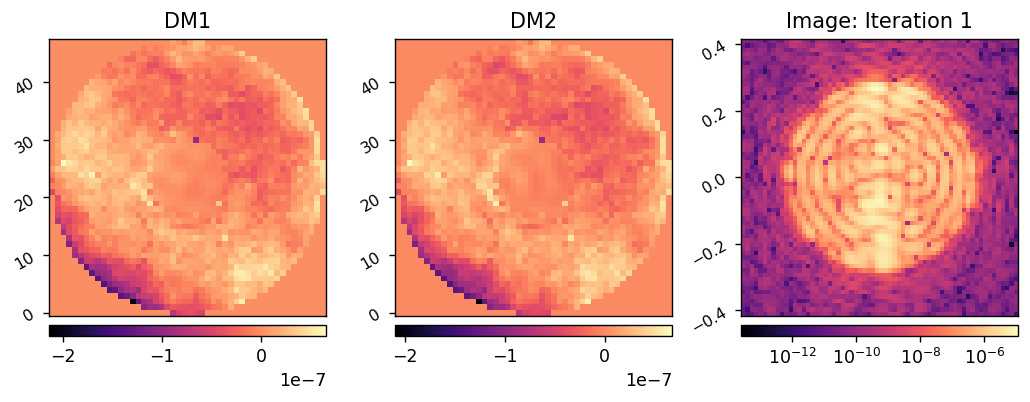

	Closed-loop iteration 2 / 5


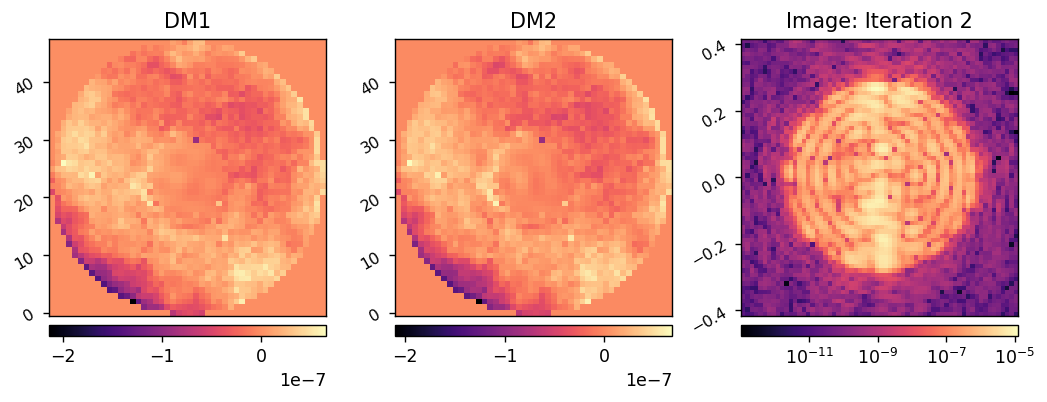

	Closed-loop iteration 3 / 5


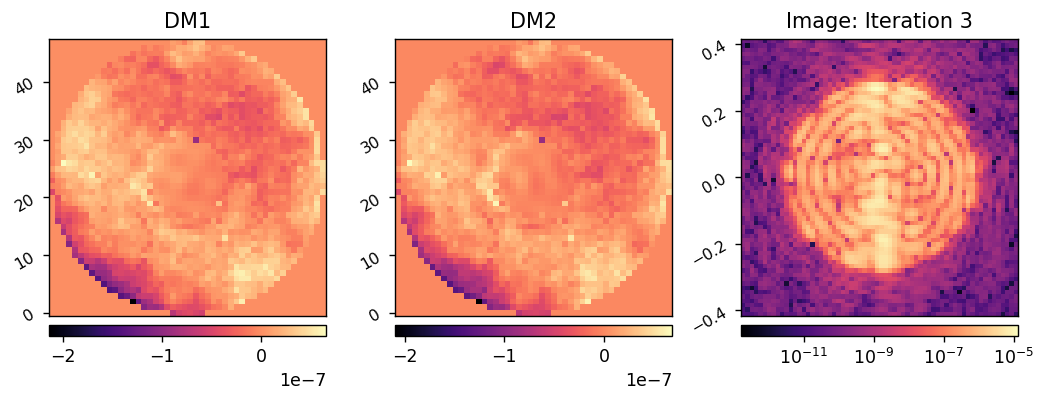

	Closed-loop iteration 4 / 5


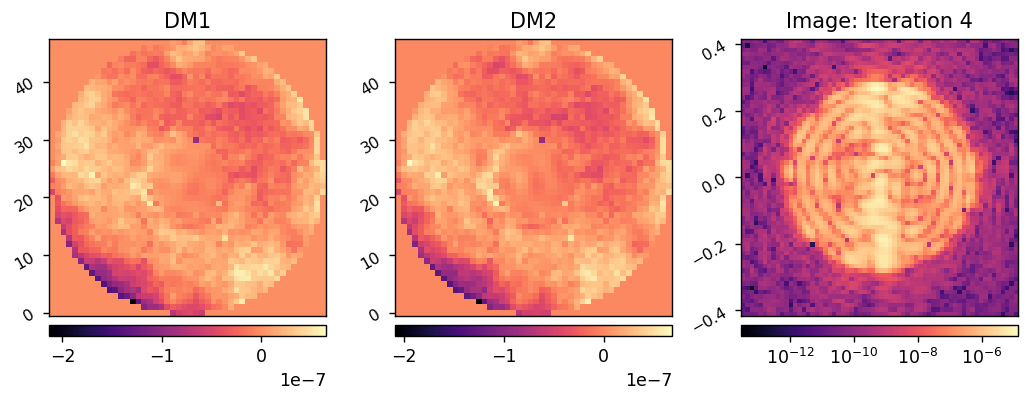

	Closed-loop iteration 5 / 5


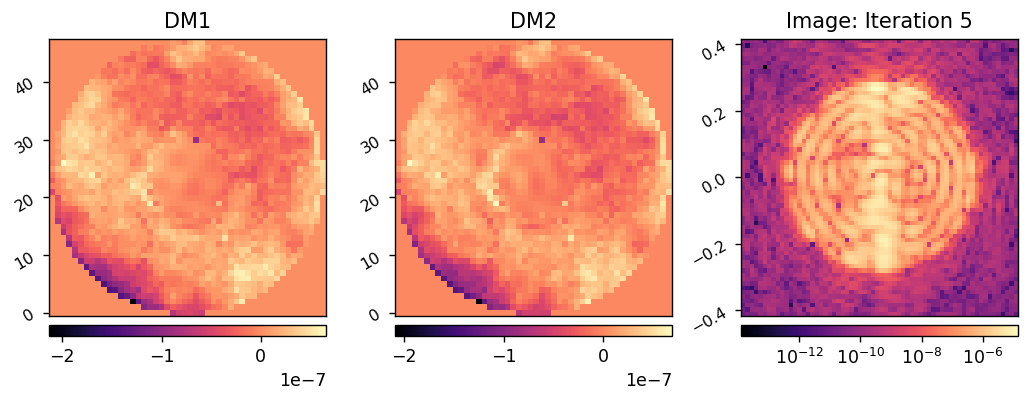

I-EFC loop completed in 9.891s.
Calibration iteration 4


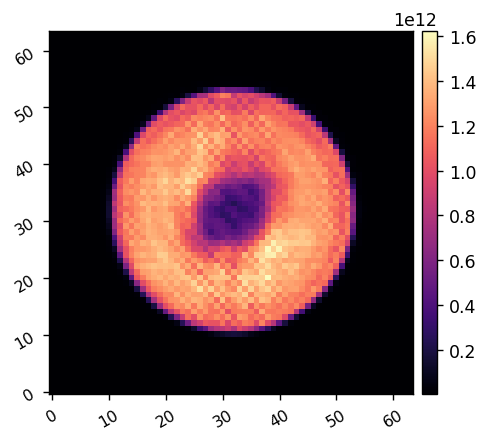

Using Weighted Least Squares 
Running I-EFC...
	Closed-loop iteration 1 / 5


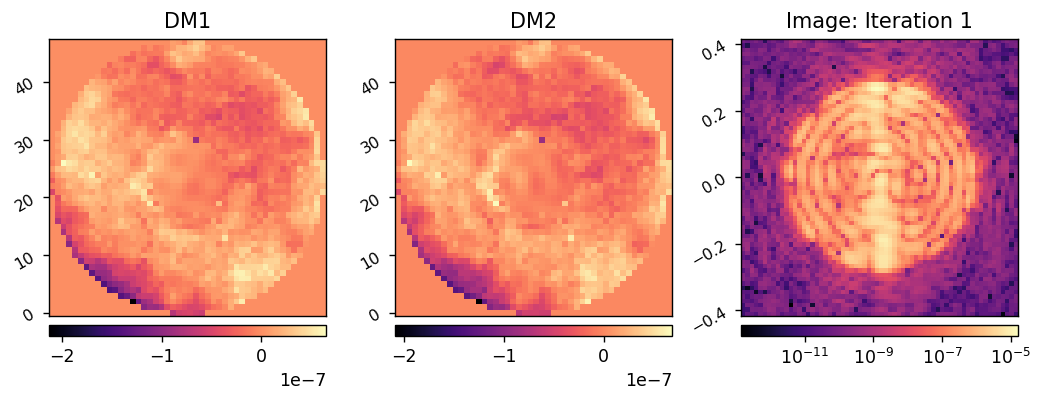

	Closed-loop iteration 2 / 5


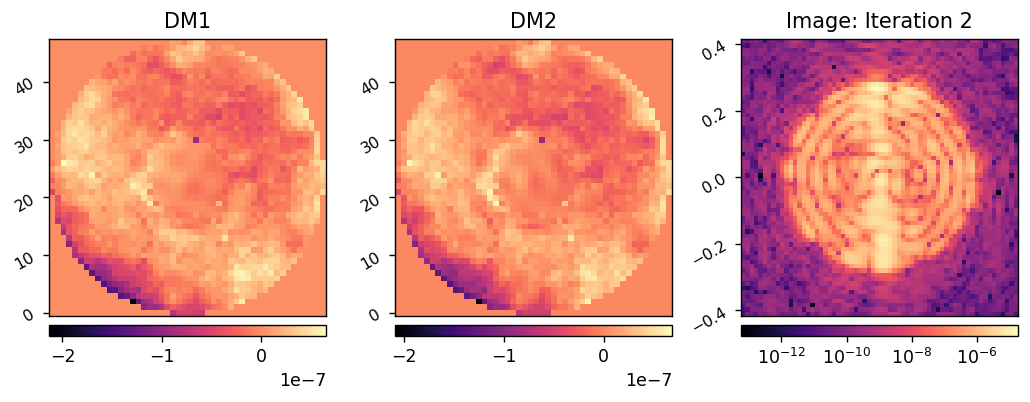

	Closed-loop iteration 3 / 5


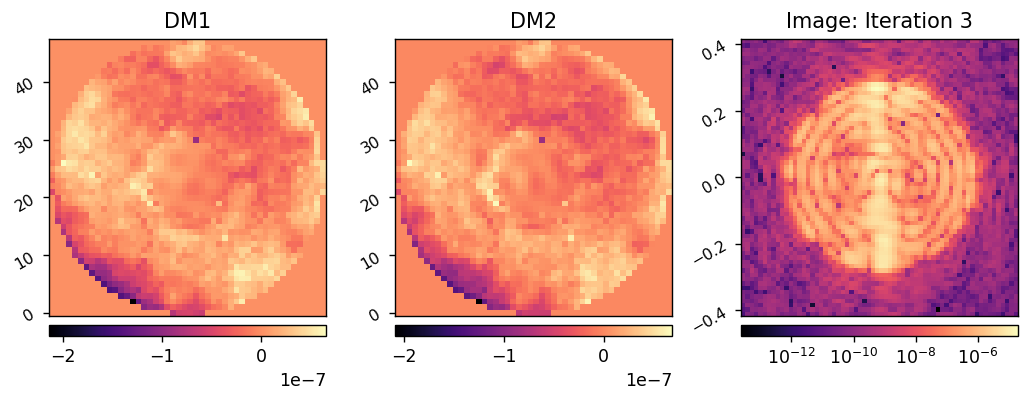

	Closed-loop iteration 4 / 5


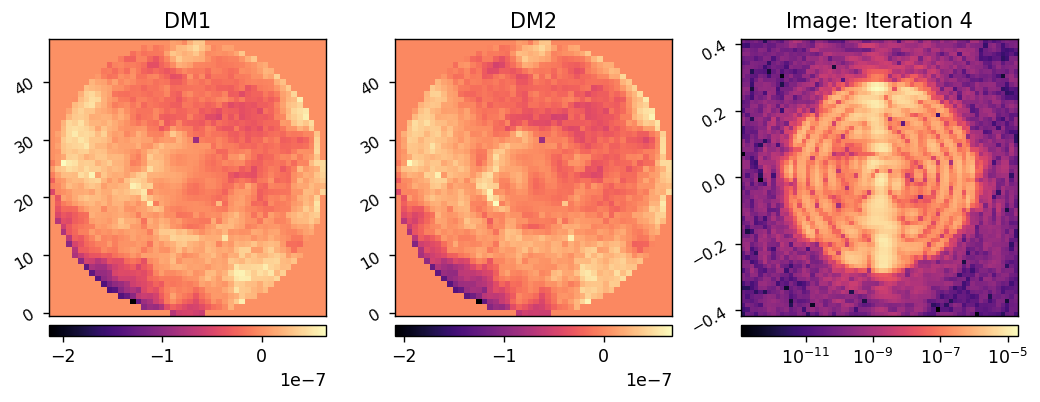

	Closed-loop iteration 5 / 5


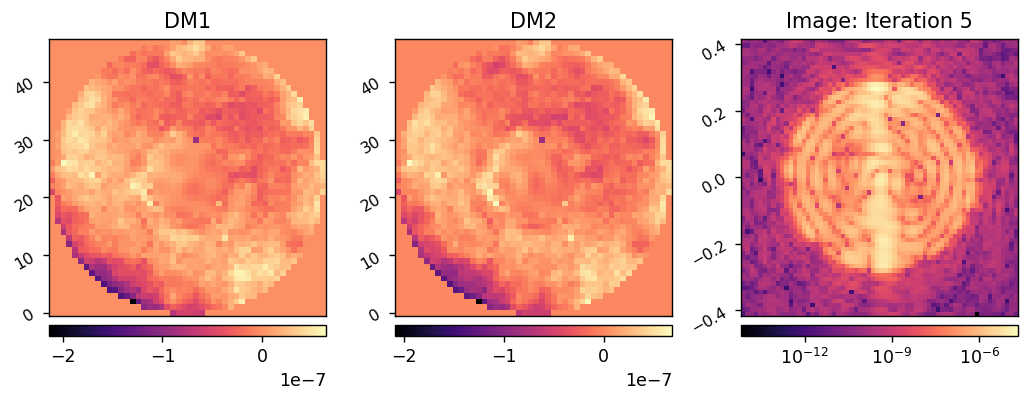

I-EFC loop completed in 9.917s.
Calibration iteration 5


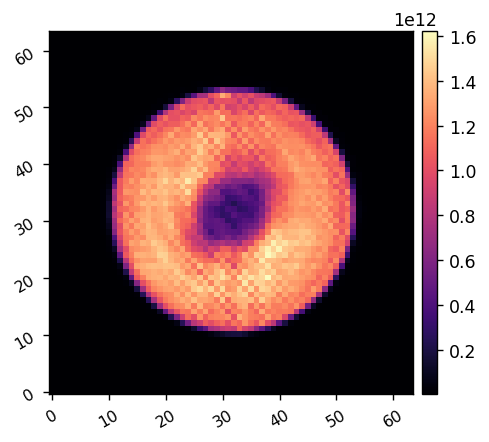

Using Weighted Least Squares 
Running I-EFC...
	Closed-loop iteration 1 / 5


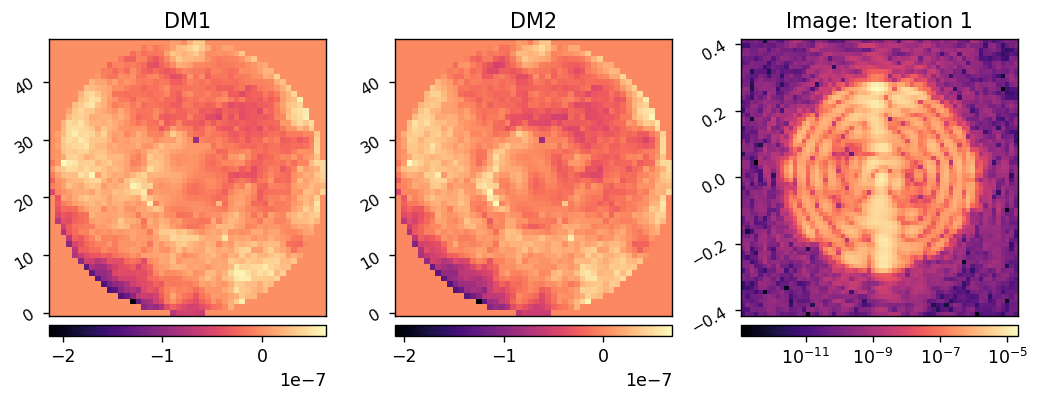

	Closed-loop iteration 2 / 5


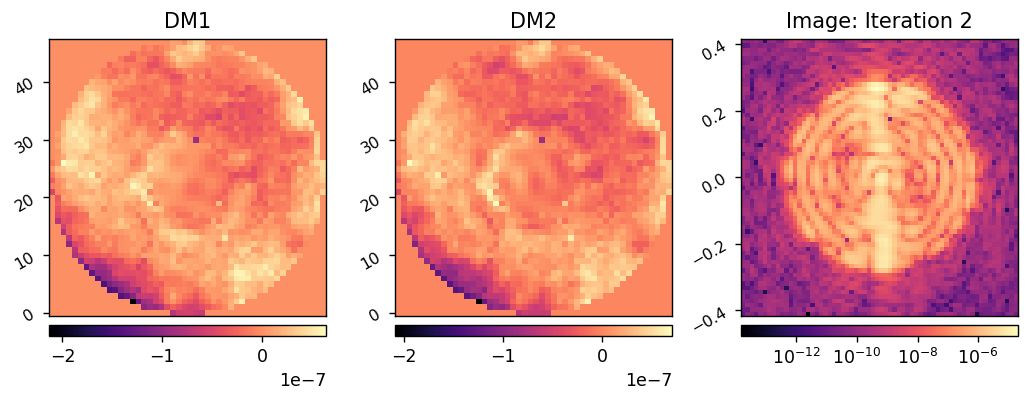

	Closed-loop iteration 3 / 5


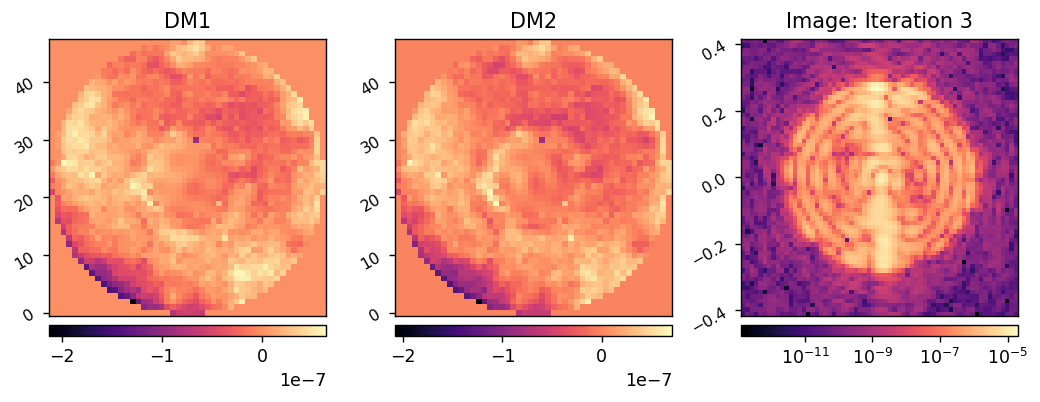

	Closed-loop iteration 4 / 5


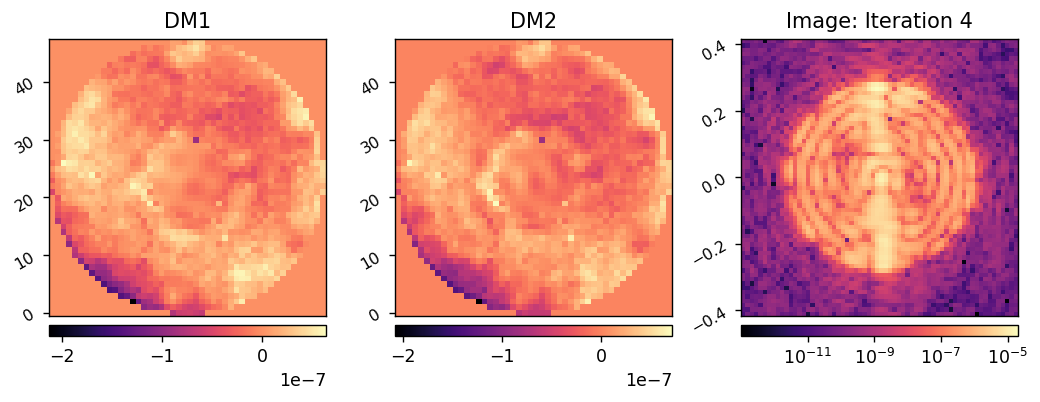

	Closed-loop iteration 5 / 5


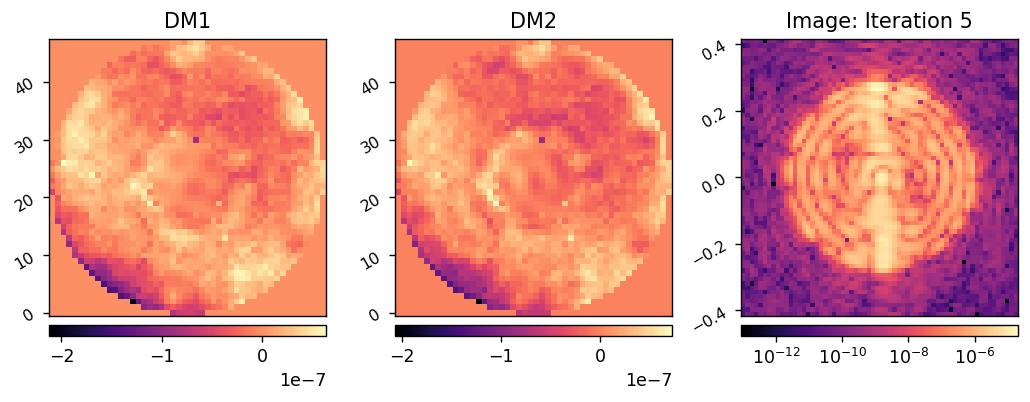

I-EFC loop completed in 9.691s.
Calibration iteration 6


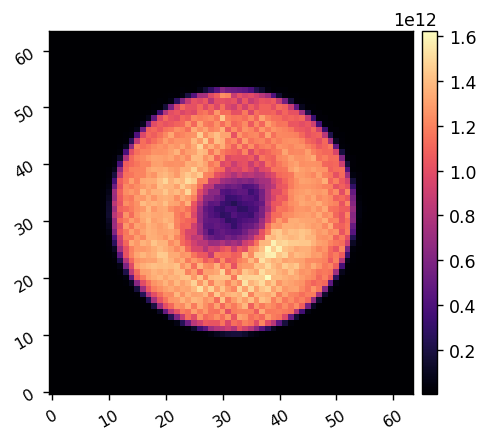

Using Weighted Least Squares 
Running I-EFC...
	Closed-loop iteration 1 / 5


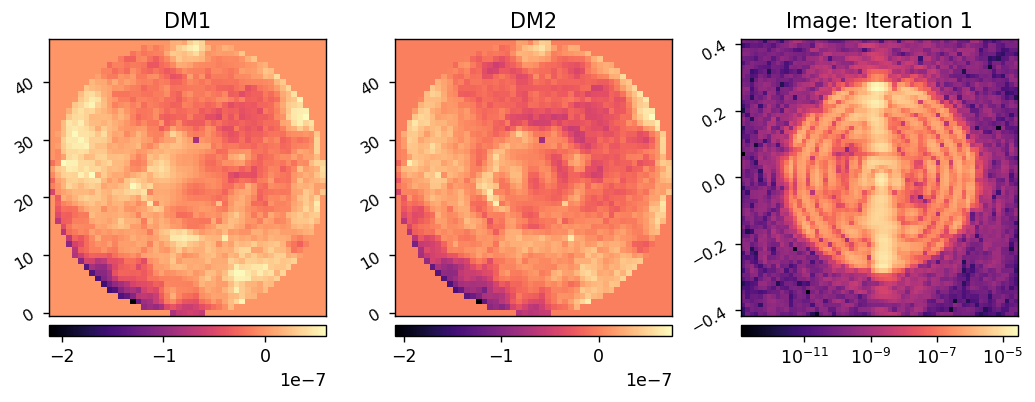

	Closed-loop iteration 2 / 5


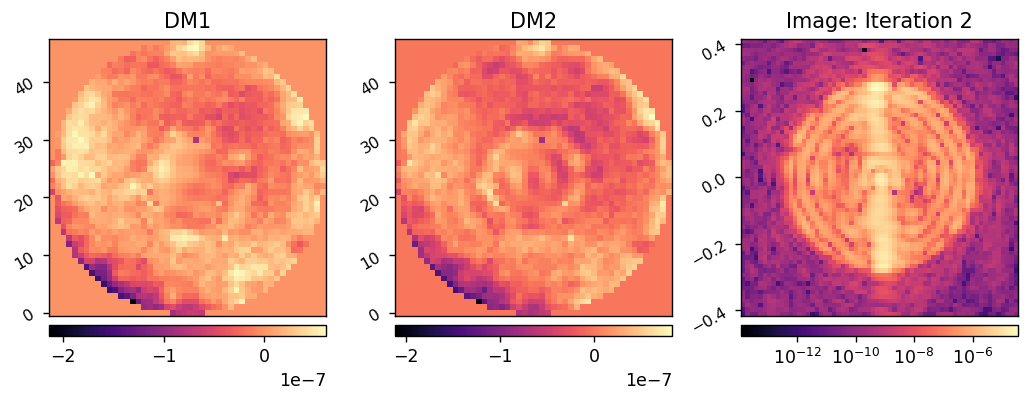

	Closed-loop iteration 3 / 5


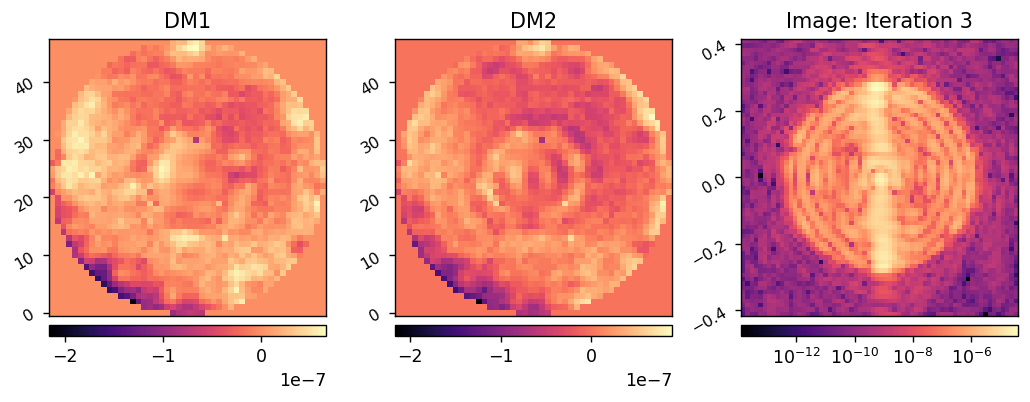

	Closed-loop iteration 4 / 5


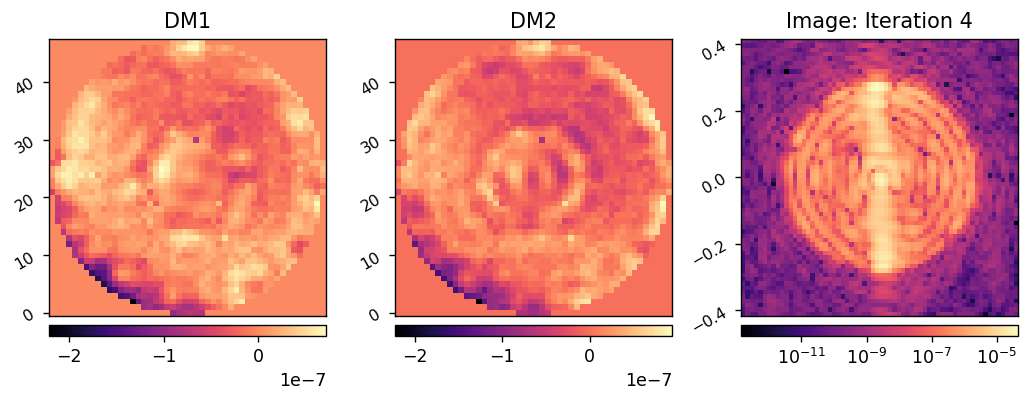

	Closed-loop iteration 5 / 5


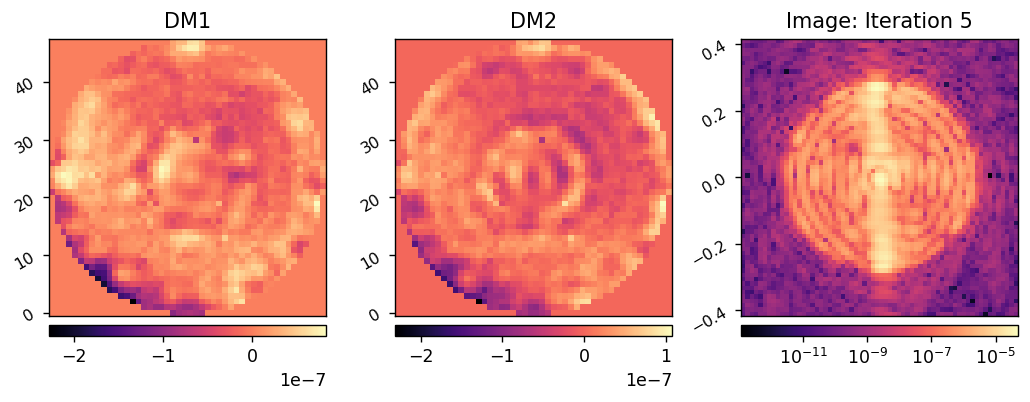

I-EFC loop completed in 10.026s.
Calibration iteration 7


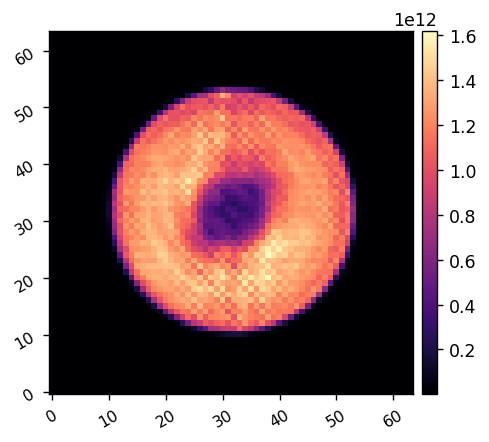

Using Weighted Least Squares 
Running I-EFC...
	Closed-loop iteration 1 / 5


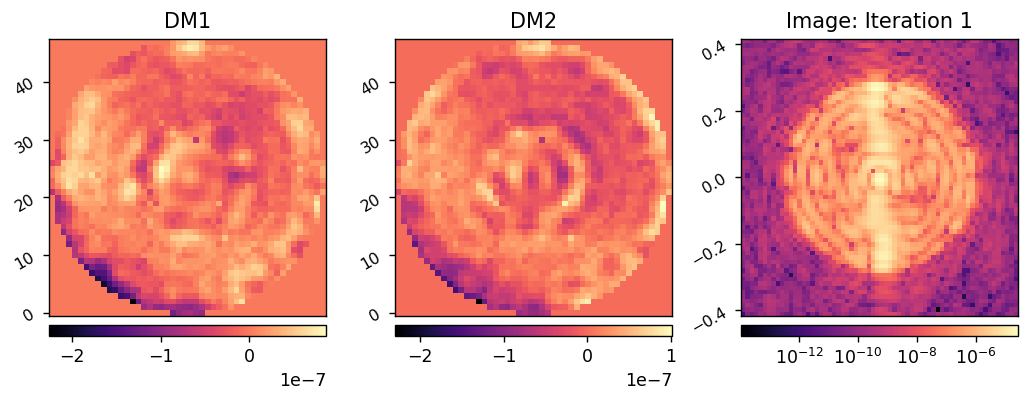

	Closed-loop iteration 2 / 5


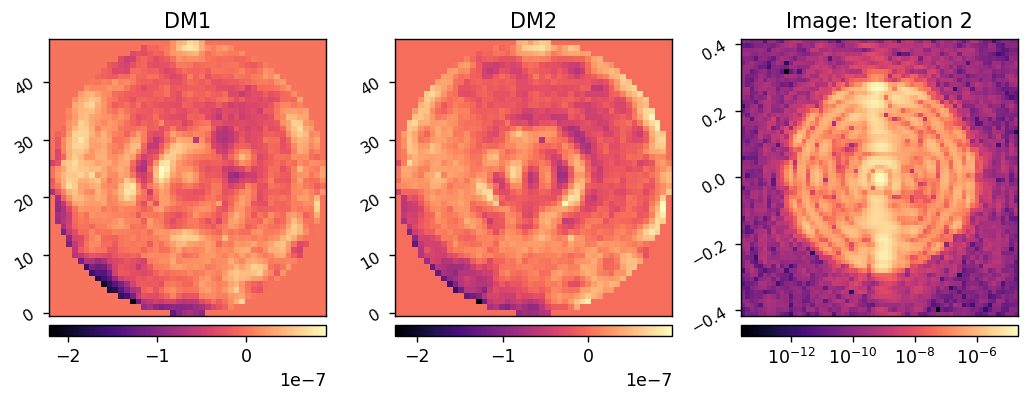

	Closed-loop iteration 3 / 5


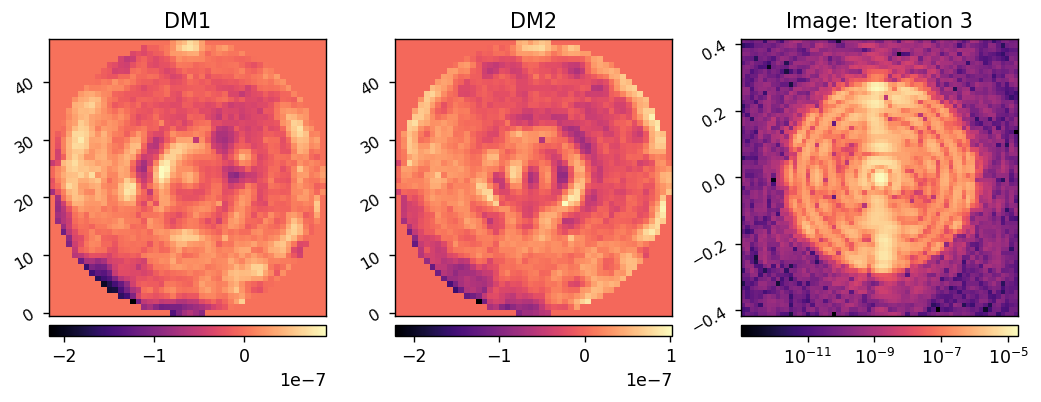

	Closed-loop iteration 4 / 5


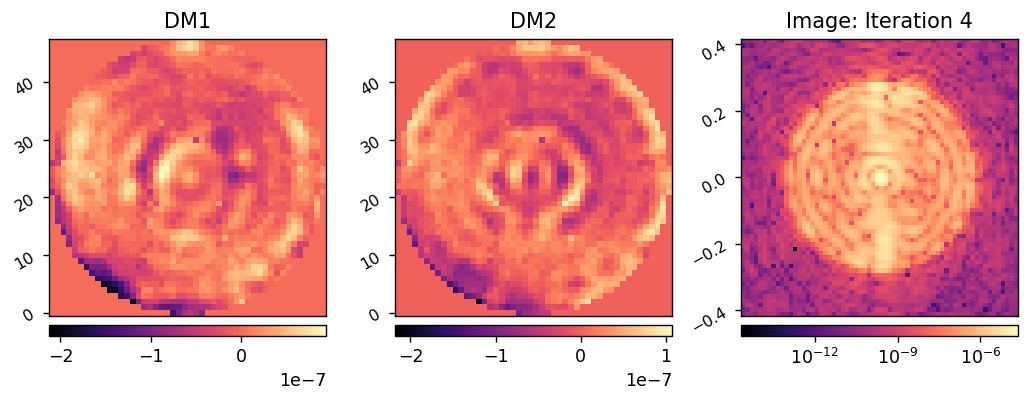

	Closed-loop iteration 5 / 5


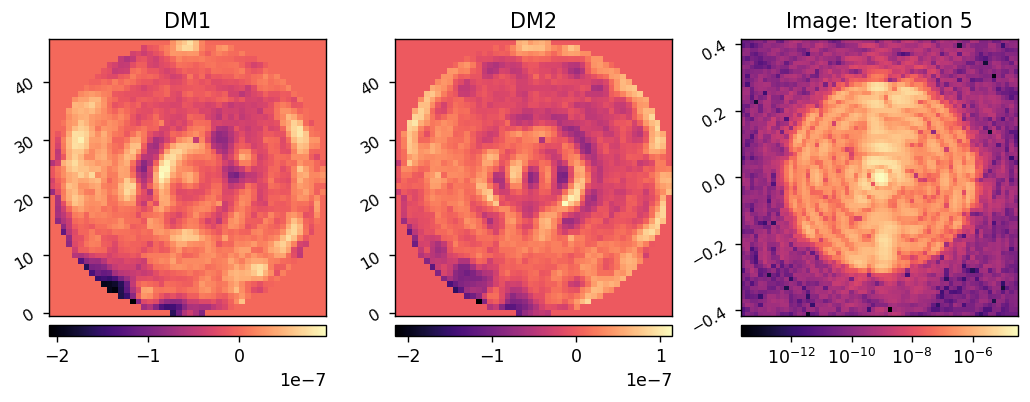

I-EFC loop completed in 9.703s.
Calibration iteration 8


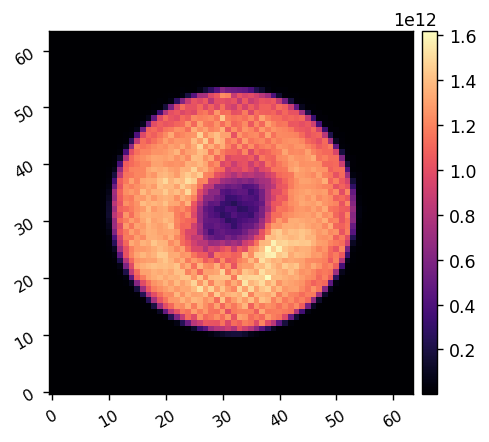

Using Weighted Least Squares 
Running I-EFC...
	Closed-loop iteration 1 / 5


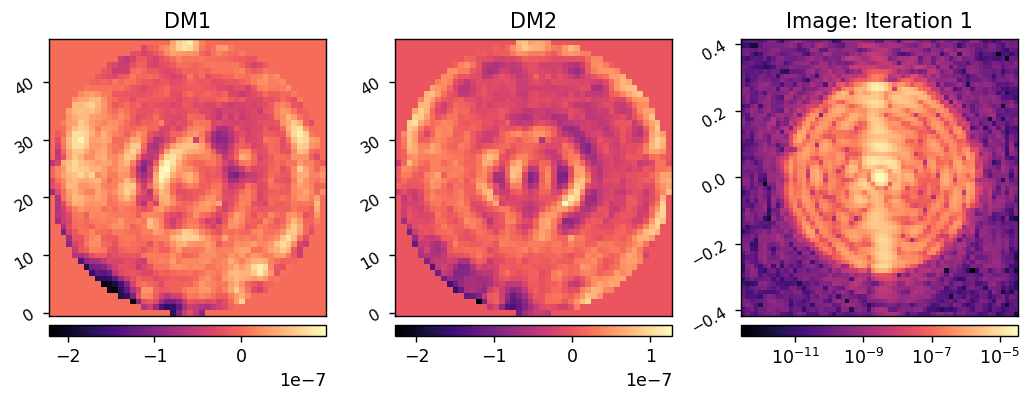

	Closed-loop iteration 2 / 5


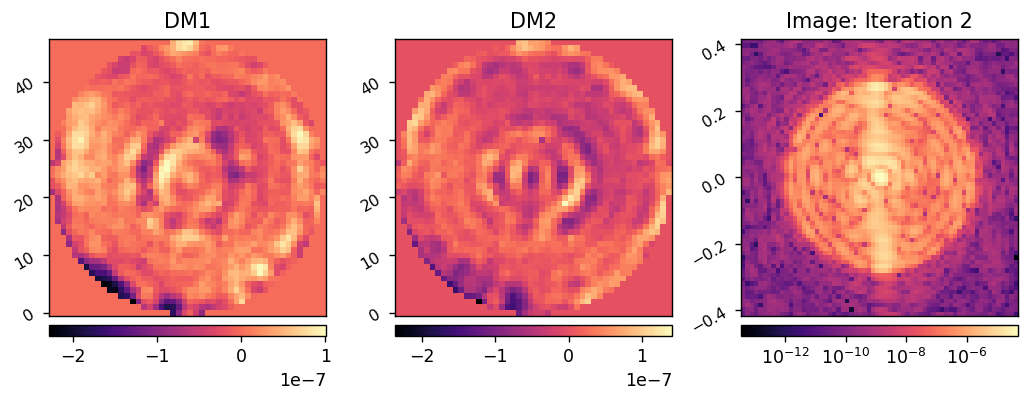

	Closed-loop iteration 3 / 5


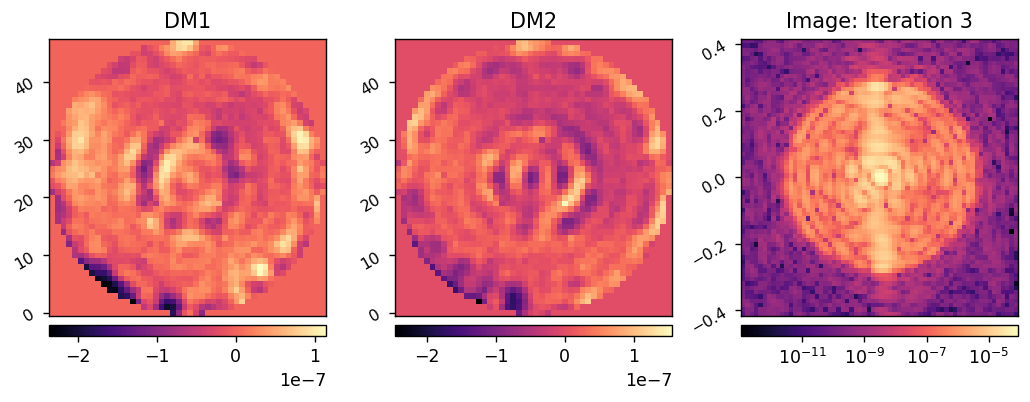

	Closed-loop iteration 4 / 5


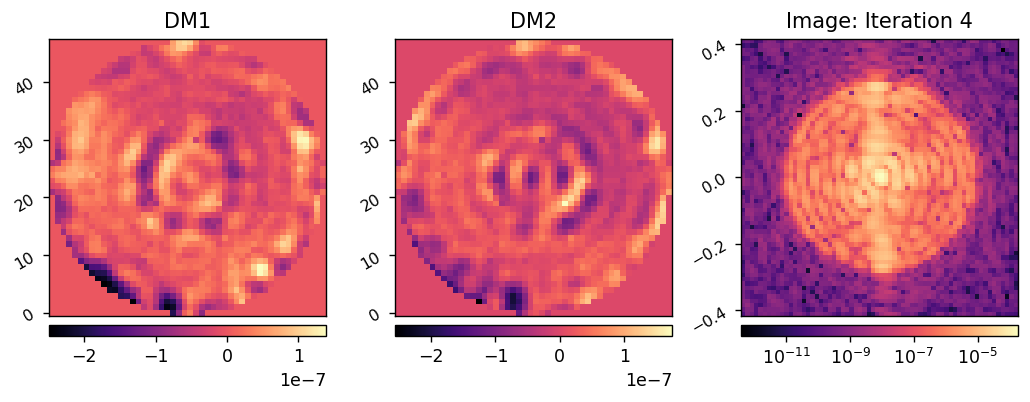

	Closed-loop iteration 5 / 5


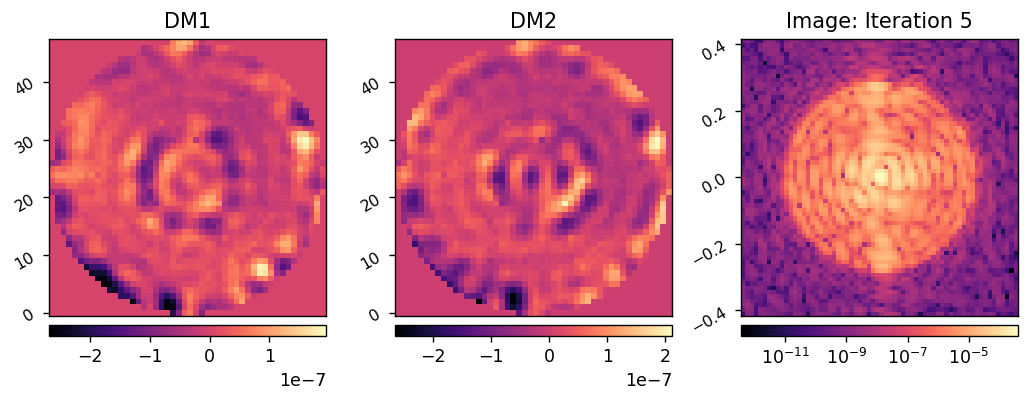

I-EFC loop completed in 9.753s.
Calibration iteration 9


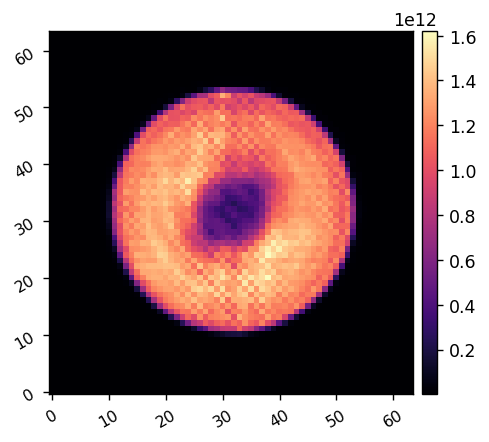

Using Weighted Least Squares 
Running I-EFC...
	Closed-loop iteration 1 / 5


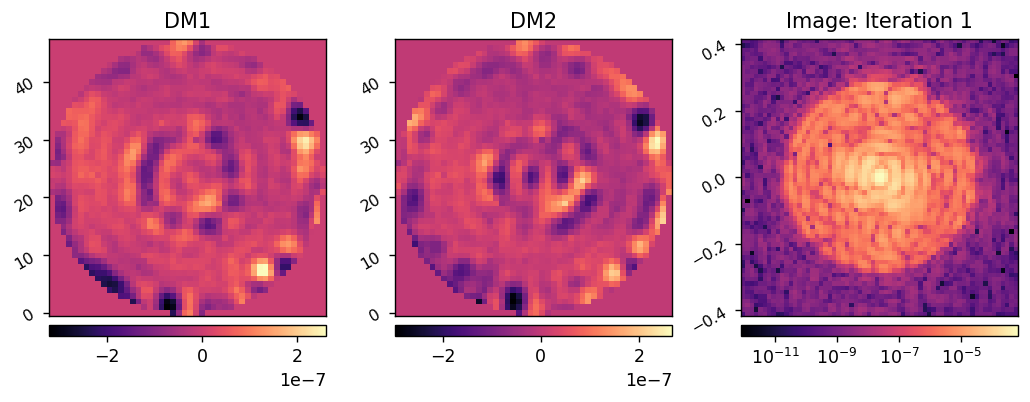

	Closed-loop iteration 2 / 5


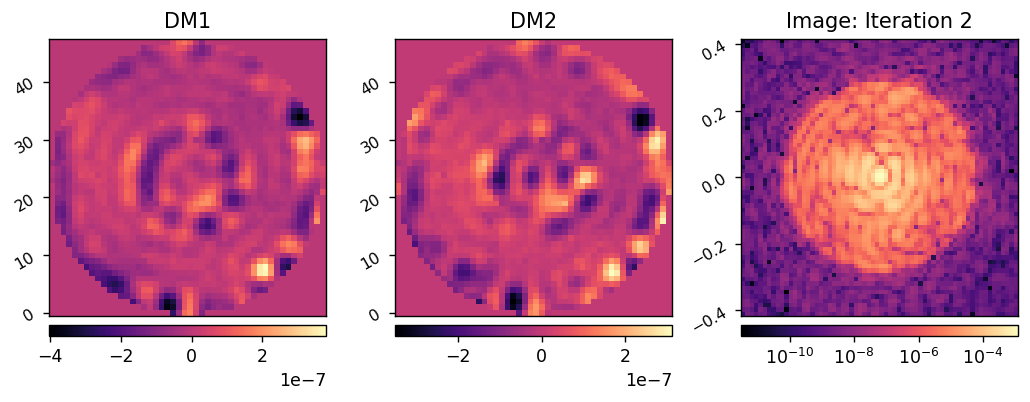

	Closed-loop iteration 3 / 5


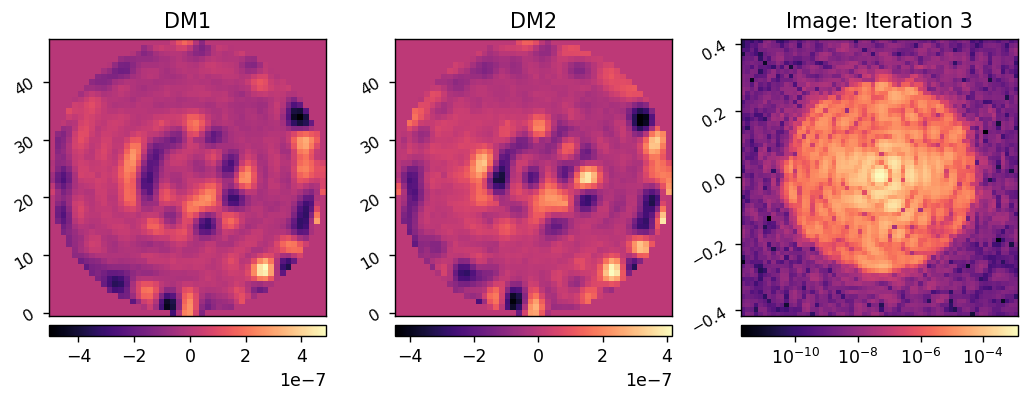

	Closed-loop iteration 4 / 5


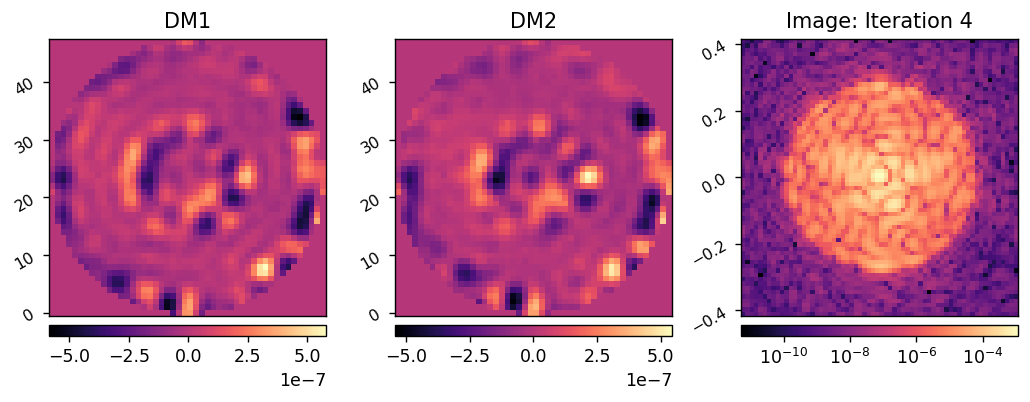

	Closed-loop iteration 5 / 5


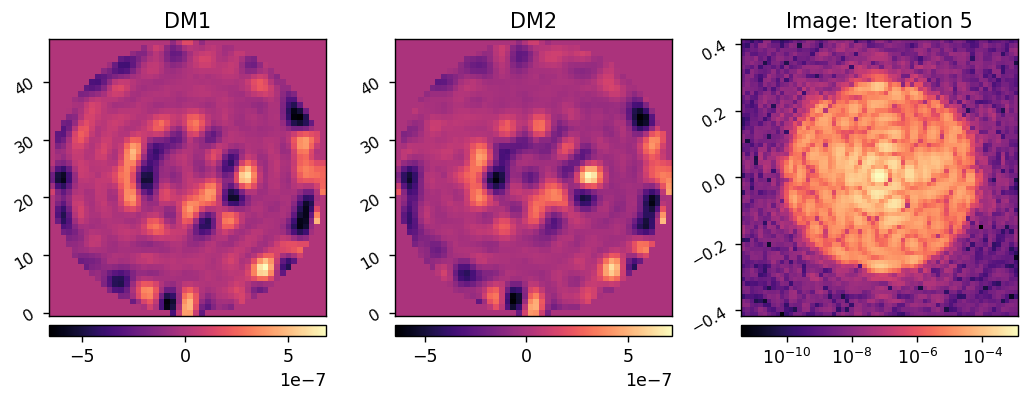

I-EFC loop completed in 9.720s.
Calibration iteration 10


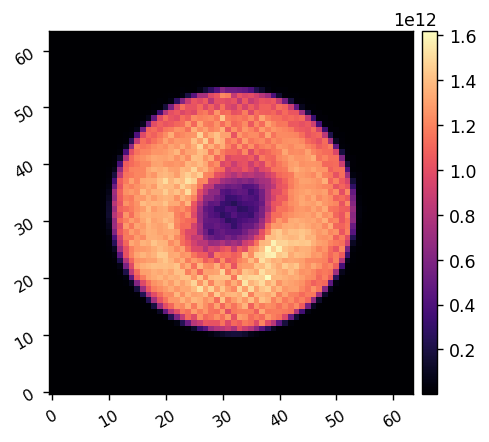

Using Weighted Least Squares 
Running I-EFC...
	Closed-loop iteration 1 / 5


KeyboardInterrupt: 

<Figure size 1250x500 with 0 Axes>

In [8]:
n_calibrations = 10
n_iefc_iterations_per_calib = 5

probe_amplitude = 0.01 * hlc.wavelength_c.to(u.m).value

reg_conds_1 = np.array([[0, 5],
                        [1e-1, 5e-3]])
reg_conds_2 = reg_conds_1

hlc.reset_dms()
hlc.show_dms()
for i in range(n_calibrations):
    print('Calibration iteration {:d}'.format(i+1))
    response_cube = response_cubes[i]
    
    response_sum = np.sum(abs(response_cube), axis=(0,1))
    misc.myimshow(response_sum.reshape(64,64))
    
    reg_cond_1 = reg_conds_1[1][np.where(reg_conds_1[0]==i)][0] if i in reg_conds_1[0] else reg_cond_1
    reg_cond_2 = reg_conds_2[1][np.where(reg_conds_2[0]==i)][0] if i in reg_conds_2[0] else reg_cond_2
    
    control_matrix = iefc.construct_control_matrix(response_cube, 
                                                   weights.flatten(), 
                                                   rcond1=reg_cond_1,
                                                   rcond2=reg_cond_2,
                                                   nprobes=probe_modes.shape[0], pca_modes=None)
    
    ims, dm1_commands, dm2_commands = iefc.run(hlc, 
                                                  control_matrix, 
                                                  probe_modes, 
                                                  probe_amplitude, 
                                                  calibration_modes, 
                                                  weights, 
                                                  num_iterations=n_iefc_iterations_per_calib, 
                                                  gain=-0.5, leakage=0.0,
                                                  display=True)
    